<a href="https://colab.research.google.com/github/taznica/ComputerVision_Assignments/blob/main/assignment1_mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define LeNet
class LeNet(nn.Module):
  def __init__(self, input_dim=1, num_class=10):
    super(LeNet, self).__init__()

    # Convolutional layers
    self.conv1 = nn.Conv2d(input_dim, 20,  kernel_size=5, stride=1, padding=0) 
    self.bn1 = nn.BatchNorm2d(20)
    self.conv2 = nn.Conv2d(20,    50,  kernel_size=5, stride=1, padding=0) 
    self.bn2 = nn.BatchNorm2d(50)
    
    # Fully connected layers
    self.fc1 = nn.Linear(800, 500)
    #self.bn3 = nn.BatchNorm1d(500)
    self.fc2 = nn.Linear(500, num_class)
    
    # Activation func.
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))                                  #  28 x 28 x 1 -> 24 x 24 x 20
    x = self.bn1(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)  # 12 x 12 x 20
    x = self.relu(self.conv2(x))                                   # -> 8 x 8 x 50
    x = self.bn2(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)  # -> 4 x 4 x 50

    b,c,h,w = x.size()                                                   # batch, channels, height, width
    x = x.view(b, -1)                                                    # flatten the tensor x -> 800

    x = self.relu(self.fc1(x))          # fc-> ReLU
    x = self.fc2(x)                           # fc
    return x

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!




/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 28, 28])
tensor([4, 9, 8, 6, 1, 1, 3, 5, 3, 8, 0, 2, 7, 5, 0, 4, 1, 0, 9, 6, 9, 9, 4, 8,
        8, 7, 6, 3, 6, 5, 8, 1, 8, 8, 1, 9, 6, 3, 6, 4, 8, 1, 0, 2, 9, 7, 7, 4,
        8, 5])


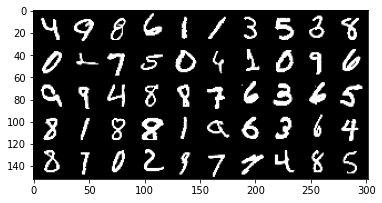

In [2]:
from   torchvision import datasets as datasets
import torchvision.transforms as transforms
import torch.utils as utils
import matplotlib.pyplot as plt
import torch
import torchvision
# To train the network, you also need 
# i)   a dataset;
# ii)  a loss function;
# iii) an optimizer.

# ------ First let's get the dataset (we use MNIST) ready ------
# We define a function (named as transform) to 
# -1) convert the data_type (np.array or Image) of an image to torch.FloatTensor;
# -2) standardize the Tensor for better classification accuracy 
# The "transform" will be used in "datasets.MNIST" to process the images.
# You can decide the batch size and whether shuffling the samples or not by setting
# "batch_size" and "shuffle" in "utils.data.DataLoader".
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
mnist_train = datasets.MNIST('./data', train=True,  download=True, transform=transform)
mnist_test  = datasets.MNIST('./data', train=False, download=True, transform=transform)
trainloader = utils.data.DataLoader(mnist_train, batch_size=50, shuffle=True,  num_workers=2)
testloader  = utils.data.DataLoader(mnist_train, batch_size=100, shuffle=False, num_workers=2)

# To see an example of a batch (10 images) of training data 
# Change the "trainloader" to "testloader" to see test data
iter_data = iter(trainloader)
#iter_data = iter(testloader)
images, labels = next(iter_data)
print(images.size())
print(labels)
# Show images
show_imgs = torchvision.utils.make_grid(images, nrow=10).numpy().transpose((1,2,0))
plt.imshow(show_imgs)


In [3]:
def evaluate_model():
  print("Testing the network...")
  net.eval()
  total_num   = 0
  correct_num = 0
  for test_iter, test_data in enumerate(testloader):
    # Get one batch of test samples
    inputs, labels = test_data    
    bch = inputs.size(0)
    #inputs = inputs.view(bch, -1) <-- We don't need to reshape inputs here (we are using CNNs).

    # Move inputs and labels into GPU
    inputs = inputs.cuda()
    labels = torch.LongTensor(list(labels)).cuda()

    # Forward
    outputs = net(inputs)   

    # Get predicted classes
    _, pred_cls = torch.max(outputs, 1)
#     if total_num == 0:
#        print("True label:\n", labels)
#        print("Prediction:\n", pred_cls)
    # Record test result
    correct_num+= (pred_cls == labels).float().sum().item()
    total_num+= bch
  net.train()
  
  print("Accuracy: "+"%.3f"%(correct_num/float(total_num)))

In [4]:
# Initialize the network
net = LeNet().cuda()
# To check the net's architecutre
print(net)

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (relu): ReLU()
)


In [5]:
# You can check the weights in a convolutional kernel (e.g., conv1) by
print(net.conv1.weight.size()) 
print(net.conv1.weight)
print(net.conv1.bias)

torch.Size([20, 1, 5, 5])
Parameter containing:
tensor([[[[ 0.0967, -0.1783, -0.1487, -0.1315,  0.1510],
          [ 0.1167, -0.0189, -0.0167, -0.1679, -0.1444],
          [ 0.0490, -0.1483, -0.1474,  0.1463,  0.1961],
          [ 0.0780,  0.0697, -0.1308, -0.1947,  0.0652],
          [-0.0808, -0.1935, -0.1726, -0.0442,  0.1660]]],


        [[[ 0.0605,  0.1368,  0.0923,  0.1424,  0.0140],
          [ 0.1753, -0.1362, -0.0735, -0.1210, -0.0792],
          [ 0.1223, -0.0066,  0.0311, -0.0189, -0.1585],
          [ 0.0562, -0.0203,  0.1214, -0.0131, -0.1254],
          [-0.0800,  0.1129, -0.0818, -0.1445, -0.0968]]],


        [[[-0.1416, -0.1750, -0.0336, -0.1543,  0.1459],
          [-0.1996,  0.1323,  0.0810,  0.1713,  0.0426],
          [ 0.0925, -0.0821,  0.1408, -0.1052, -0.0372],
          [-0.0353,  0.0888, -0.1683,  0.0733, -0.1695],
          [ 0.0226, -0.1883,  0.0568, -0.0081,  0.1269]]],


        [[[-0.1956,  0.0908,  0.1878,  0.1554,  0.0491],
          [ 0.1365, -0.1991,

In [6]:
# ------ We define the loss function and the optimizer -------
import torch.optim as optim
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
epoch = 0

In [7]:
running_loss = 0.0
ct_num = 0
for iteration, data in enumerate(trainloader):
  # Take the inputs and the labels for 1 batch.
  inputs, labels = data
  bch = inputs.size(0)
  #inputs = inputs.view(bch, -1) <-- We don't need to reshape inputs here (we are using CNNs).
  
  # Move inputs and labels into GPU
  inputs = inputs.cuda()
  labels = labels.cuda()

  # Remove old gradients for the optimizer.
  optimizer.zero_grad()

  # Compute result (Forward)
  outputs = net(inputs)

  # Compute loss
  loss    = loss_func(outputs, labels)

  # Calculate gradients (Backward)
  loss.backward()

  # Update parameters
  optimizer.step()
  
  #with torch.no_grad():
  running_loss += loss.item()
  ct_num+= 1
  if iteration%50 == 49:
    #print("Iteration: "+str(iteration+1)+", Loss: "+str(running_loss/ct_num)+'.')
    print("[Epoch: "+str(epoch+1)+"]"" --- Iteration: "+str(iteration+1)+", Loss: "+str(running_loss/ct_num)+'.')
  # Test
  if iteration%300 == 299:
    evaluate_model()
        
epoch += 1

[Epoch: 1] --- Iteration: 50, Loss: 1.5677400720119476.
[Epoch: 1] --- Iteration: 100, Loss: 1.04460124745965.
[Epoch: 1] --- Iteration: 150, Loss: 0.7939526431759198.
[Epoch: 1] --- Iteration: 200, Loss: 0.6499801807850599.
[Epoch: 1] --- Iteration: 250, Loss: 0.555989214092493.
[Epoch: 1] --- Iteration: 300, Loss: 0.49090754757324856.
Testing the network...
Accuracy: 0.963
[Epoch: 1] --- Iteration: 350, Loss: 0.44048927705202784.
[Epoch: 1] --- Iteration: 400, Loss: 0.40243537198752166.
[Epoch: 1] --- Iteration: 450, Loss: 0.3720921637531784.
[Epoch: 1] --- Iteration: 500, Loss: 0.3465566368699074.
[Epoch: 1] --- Iteration: 550, Loss: 0.3248367077383128.
[Epoch: 1] --- Iteration: 600, Loss: 0.30645176672531915.
Testing the network...
Accuracy: 0.974
[Epoch: 1] --- Iteration: 650, Loss: 0.29062800884103546.
[Epoch: 1] --- Iteration: 700, Loss: 0.2765443186501839.
[Epoch: 1] --- Iteration: 750, Loss: 0.263368478530397.
[Epoch: 1] --- Iteration: 800, Loss: 0.25226250873995015.
[Epoch: 1